In [1]:
import json
import pandas as pd
import hvplot.pandas
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sales_data_path = "C:\\Users\\Banni\\Desktop\\Project_1\\Serge\\file.csv"

sales_data = pd.read_csv(sales_data_path)

sales_data.head()


,Unnamed: 0,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,...,Avg_Price,Delivery_Charges,Coupon_Status,GST,Date,Offline_Spend,Online_Spend,Month,Coupon_Code,Discount_pct
0,0,17850.0,M,Chicago,12.0,16679.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
1,1,17850.0,M,Chicago,12.0,16680.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
2,2,17850.0,M,Chicago,12.0,16696.0,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,...,122.77,6.5,Not Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
3,3,17850.0,M,Chicago,12.0,16699.0,2019-01-01,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,...,81.50,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
4,4,17850.0,M,Chicago,12.0,16700.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0


In [2]:

#dropping redundant and un-needed columns
sales_data_cleaned = sales_data.drop(['Unnamed: 0', 'Tenure_Months', 'Transaction_Date', 'GST', 'Offline_Spend', 'Online_Spend', 'Month', 'Coupon_Code', 'Discount_pct'], axis=1)


#dropping rows that have incomplete data
sales_data_cleaned = sales_data_cleaned.dropna()


#converting the date to unix time format for the api request & and adding it to a column
sales_data_cleaned['Date'] = pd.to_datetime(sales_data_cleaned['Date'])

sales_data_cleaned["Unix Date"] = sales_data_cleaned['Date'].apply(lambda x: int(x.timestamp()))


sales_data_cleaned.head()

,CustomerID,Gender,Location,Transaction_ID,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Unix Date
0,17850.0,M,Chicago,16679.0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Used,2019-01-01,1546300800
1,17850.0,M,Chicago,16680.0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Used,2019-01-01,1546300800
2,17850.0,M,Chicago,16696.0,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2.0,122.77,6.5,Not Used,2019-01-01,1546300800
3,17850.0,M,Chicago,16699.0,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,1.0,81.50,6.5,Clicked,2019-01-01,1546300800
4,17850.0,M,Chicago,16700.0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Clicked,2019-01-01,1546300800


In [3]:
#getting 100 random rows for each city
np.random.seed(42)

def random_rows(group):
    return group.sample(min(len(group), 50))

sales_data_random_cleaned = sales_data_cleaned.groupby('Location', group_keys=False).apply(random_rows)


#hard cording the city coordinates
city_coordinates = {
    "Chicago": (41.8781, -87.6298),
    "California": (36.7783, -119.4179),
    "New Jersey": (40.0583, -74.4057),
    "New York": (40.7128, -74.0060),
    "Washington DC": (38.8951, -77.0364),
}

#adding latitude and longitude columns
sales_data_random_cleaned["Lat"] = sales_data_random_cleaned["Location"].map(city_coordinates).apply(lambda x: x[0])
sales_data_random_cleaned["Lon"] = sales_data_random_cleaned["Location"].map(city_coordinates).apply(lambda x: x[1])


#adding blank weather conditions column
sales_data_random_cleaned["Weather Conditions"] = ""

sales_data_random_cleaned.head()

,CustomerID,Gender,Location,Transaction_ID,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Unix Date,Lat,Lon,Weather Conditions
23680,14307.0,F,California,38830.0,GGOEGOAR013099,Google Stylus Pen w/ LED Light,Office,75.0,4.40,82.48,Clicked,2019-09-23,1569196800,36.7783,-119.4179,
6316,14911.0,F,California,45554.0,GGOEGAYB068026,Google Youth Baseball Raglan Heather/Black,Apparel,1.0,10.18,6.50,Clicked,2019-12-04,1575417600,36.7783,-119.4179,
44290,17085.0,F,California,31959.0,GGOEGOCB017499,Leatherette Journal,Office,30.0,8.79,36.06,Clicked,2019-07-06,1562371200,36.7783,-119.4179,
23304,17787.0,M,California,39212.0,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,149.00,6.00,Not Used,2019-09-27,1569542400,36.7783,-119.4179,
25591,14527.0,M,California,38656.0,GGOEGBJC014399,Google Tote Bag,Bags,1.0,9.99,6.00,Clicked,2019-09-21,1569024000,36.7783,-119.4179,


In [4]:
sales_data="C:\\Users\\Banni\\Desktop\\Project_1\\Serge\\sales_data_final.csv"
sales_data_final_df=pd.read_csv(sales_data)
sales_data_final_df

,CustomerID,Gender,Location,Transaction_ID,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Date,Temperature (F),Weather Conditions
0,14307.0,F,California,38830.0,Google Stylus Pen w/ LED Light,Office,75.0,4.40,82.48,Clicked,2019-09-23,89.82,clear sky
1,14911.0,F,California,45554.0,Google Youth Baseball Raglan Heather/Black,Apparel,1.0,10.18,6.50,Clicked,2019-12-04,55.81,mist
2,17085.0,F,California,31959.0,Leatherette Journal,Office,30.0,8.79,36.06,Clicked,2019-07-06,95.90,clear sky
3,17787.0,M,California,39212.0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,149.00,6.00,Not Used,2019-09-27,93.34,clear sky
4,14527.0,M,California,38656.0,Google Tote Bag,Bags,1.0,9.99,6.00,Clicked,2019-09-21,81.27,clear sky
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,18055.0,F,Washington DC,23328.0,26 oz Double Wall Insulated Bottle,Drinkware,2.0,19.99,6.50,Clicked,2019-03-19,46.47,overcast clouds
246,17796.0,F,Washington DC,20601.0,Google Doodle Decal,Office,1.0,2.99,6.50,Clicked,2019-02-16,56.32,overcast clouds
247,15723.0,F,Washington DC,26471.0,Nest Cam Indoor Security Camera - USA,Nest-USA,1.0,119.00,6.00,Used,2019-04-26,70.14,overcast clouds
248,17976.0,M,Washington DC,18700.0,Google Women's Fleece Hoodie,Apparel,1.0,57.76,6.50,Used,2019-01-24,47.53,overcast clouds


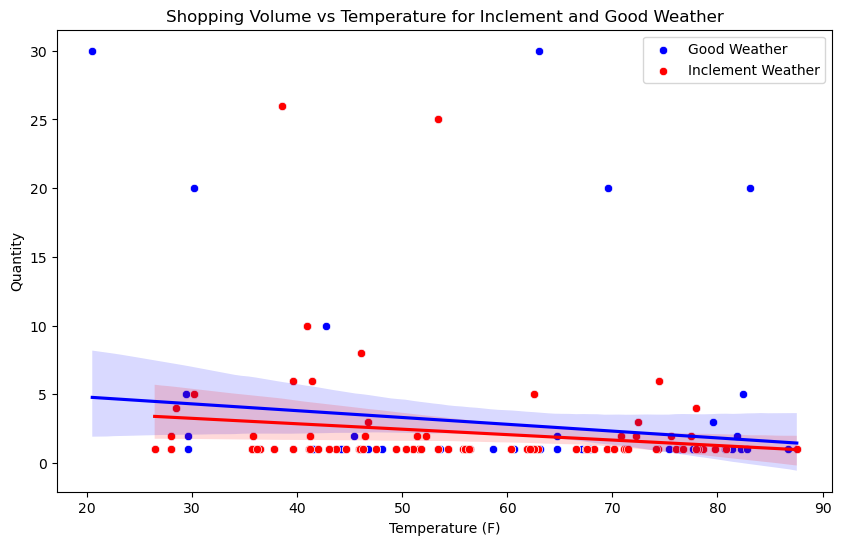

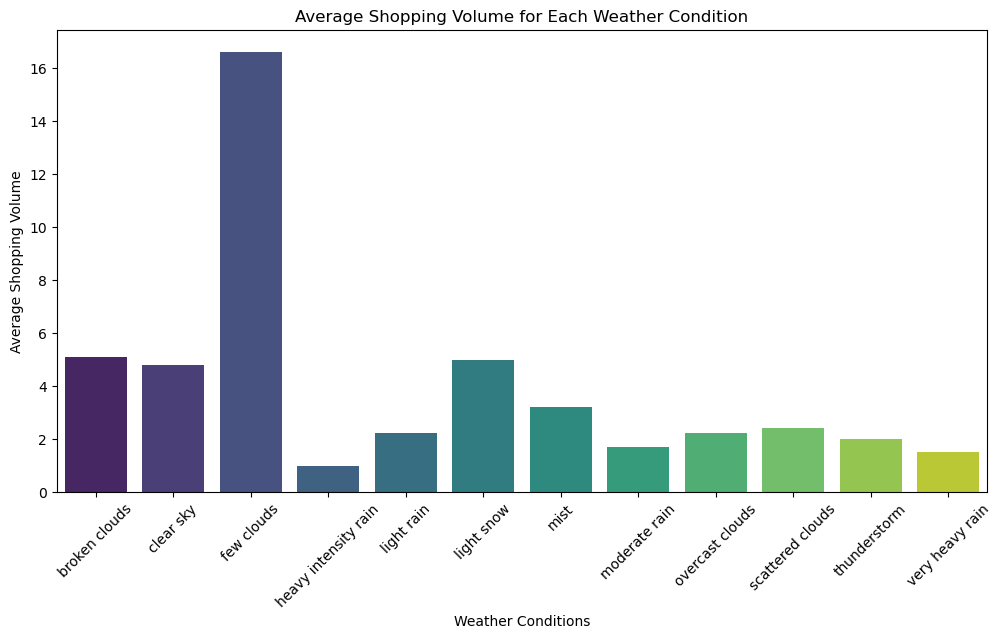

In [6]:
###How does inclement weather affect shopping habits?
## compare if the volume of shopping increased during inclement weather (light rain, moderate rain, heavy rain, mist, overcast?) and good weather (clear sky, scattered clouds, etc.)
## scatter plot & lin regress & bar graph maybe

inclement_weather = sales_data_final_df[sales_data_final_df['Weather Conditions'].isin(['light rain', 'moderate rain', 'heavy rain', 'mist', 'overcast clouds'])]
good_weather = sales_data_final_df[~sales_data_final_df['Weather Conditions'].isin(["clear sky", "scattered clouds", "few clouds"])]

# Scatter plot for both inclement and good weather
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature (F)', y='Quantity', data=good_weather, label='Good Weather', color='blue')
sns.scatterplot(x='Temperature (F)', y='Quantity', data=inclement_weather, label='Inclement Weather', color='red')

# Regression lines
sns.regplot(x='Temperature (F)', y='Quantity', data=good_weather, scatter=False, color='blue')
sns.regplot(x='Temperature (F)', y='Quantity', data=inclement_weather, scatter=False, color='red')

plt.legend()
plt.title('Shopping Volume vs Temperature for Inclement and Good Weather')
plt.show()

avg_quantity_by_weather = sales_data_final_df.groupby('Weather Conditions')['Quantity'].mean().reset_index()


# Bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x='Weather Conditions', y='Quantity', data=avg_quantity_by_weather, palette='viridis')
plt.xticks(rotation=45)
plt.ylabel('Average Shopping Volume')
plt.title('Average Shopping Volume for Each Weather Condition')
plt.show()






In [ ]:
#how do extreme temps affect online shopping habits
# compare if temperatures affect online shopping habits (scatter plot & lin regress)

##larry


In [ ]:
#how does season affect online shopping habits


#Emely

In [ ]:
#how does gender impact online shopping habits

#Emely

In [ ]:
#does the availability of discounts or promotions influence online shopping behavior on online shopping habits  

#rebecca

In [ ]:
#are promotions or discounts used more often during inclement weather

#rebecca

In [ ]:
#is there a correlation between the peak shopping season and the occurrence of the most extreme temperatures within a given geographical region

#Larry

In [ ]:
#does the severity of weather influence online shopping behavior?
it does not.
#Sergio

In [ ]:
#is there a correlation between inclement weather and product category?

#matt